# Hito 2: Minería de Datos - Grupo 17
## Integrantes:
- Claudio Morel - Sección 1
- Damián Gonzalez - Sección 1
- Francisco Márquez - Sección 1
- Joaquín Gonzalez - Sección 1
- Nicolás Soto - Sección 2

# Introducción: plantear el problema y la motivación.

La pandemia de COVID-19 ha dejado en evidencia una problemática que ha persistido durante mucho tiempo: la escasez de camas hospitalarias para atender a todos los pacientes. En Chile hay un total de 37,397 camas hospitalarias de diferentes niveles de atención, lo que equivale a 1.92 camas por cada 1,000 habitantes. Esto muestra una escasez de camas hospitalarias en comparación con el promedio de los países de la OCDE, que es de 3.6 camas por cada 1,000 habitantes. Esta situación ha subrayado la necesidad urgente de contar con herramientas que permitan gestionar de manera eficiente los recursos del sistema hospitalario.
 
Motivado por la realidad del sistema de salud pública en Chile, marcado por largos tiempos de espera y colapsos en la entrega de servicios básicos en situaciones críticas, surge la necesidad de buscar formas de anticipar y planificar la distribución de recursos y personal de manera efectiva. En respuesta a esta necesidad, se ha emprendido un proyecto de minería de datos que analiza un conjunto de datos de egresos hospitalarios de los años 2020, 2021 y 2022, proporcionados por el Ministerio de salud del gobierno de Chile, con el objetivo de identificar relaciones y patrones que permitan abordar el problema mencionado y mejorar la capacidad de respuesta del sistema de salud ante situaciones similares en el futuro.

# Exploración de datos

## Limpieza y manipulación de datos

Para el proyecto se trabajó con datasets extraídos de la página del ministerio de salud de Chile. Estos datasets contienen información con respecto a los egresos hospitalarios ocurridos durante un año determinado. Se tienen características tanto del paciente como del proceso en sí. Por ejemplo, con respecto al paciente tenemos su etnia, sexo, grupo etario, país de origen, comuna y ciudad de residencia, pertenencia al sistema nacional de salud, y el tipo de previsión. En cuanto al proceso en sí, se tiene el año de egreso, la cantidad de días de estadía, el diagnóstico principal, la condición de egreso del paciente (si sobrevivió o no), y por último, si el paciente fue intervenido quirúrgicamente o no.

En un principio se tuvo 3 datasets, correspondientes a los años 2020, 2021 y 2022, los cuales fueron reunidos en un solo dataset principal. Este dataset final contiene alrededor de 4 millones de tuplas y cada paciente cuenta con 18 atributos. 


In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np


# Load the dataset
dataset_2022 = pd.read_csv('\\EGRESOS_2022\\EGRE_DATOS_ABIERTOS_2022.csv', delimiter=';',encoding='latin1')
dataset_2021 = pd.read_csv('C:\\Users\\joako\\Documents\\Tareas\\mineria\\EGRESOS_2021\\EGRE_DATOS_ABIERTOS_2021.csv', delimiter=';',encoding='latin1')
dataset_2020 = pd.read_csv('C:\\Users\\joako\\Documents\\Tareas\\mineria\\EGRESOS_2020\\EGRE_DATOS_ABIERTOS_2020.csv', delimiter=';',encoding='latin1')


C:\Users\joako\AppData\Local\Temp\ipykernel_11980\2174995651.py:9: DtypeWarning: Columns (7,9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset_2022 = pd.read_csv('..\\EGRESOS_2022\\EGRE_DATOS_ABIERTOS_2022.csv', delimiter=';',encoding='latin1')
C:\Users\joako\AppData\Local\Temp\ipykernel_11980\2174995651.py:10: DtypeWarning: Columns (7,9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset_2021 = pd.read_csv('..\\EGRESOS_2021\\EGRE_DATOS_ABIERTOS_2021.csv', delimiter=';',encoding='latin1')
C:\Users\joako\AppData\Local\Temp\ipykernel_11980\2174995651.py:11: DtypeWarning: Columns (7,9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset_2020 = pd.read_csv('..\\EGRESOS_2020\\EGRE_DATOS_ABIERTOS_2020.csv', delimiter=';',encoding='latin1')


Primero incluimos las librerías necesarias e importamos los archivos csv con los datos (Las rutas solo funcionan en la máquina local)

In [4]:
dataset_2022['INTERV_Q'] = dataset_2022['GLOSA_INTERV_Q_PPAL'].apply(lambda x: 2 if pd.isna(x) else 1)
dataset_2022['PROCED'] = dataset_2022['GLOSA_PROCED_PPAL'].apply(lambda x: 2 if pd.isna(x) else 1)
dataset_2022 = dataset_2022.drop(['GLOSA_INTERV_Q_PPAL','GLOSA_PROCED_PPAL'],axis=1)


En el código anterior, lo  que se hizo fue generar los valores tanto de las categorías INTERV_Q y PROCED del dataset correspondiente al año 2022 utilizando los valores de la columna GLOSA_INTERVAL_Q_PPAL. Esto se hizo debido a que en los datasets de los años 2020 y 2021 no se tenían estas  categorías. De esta forma, modificamos los datasets para que todos tengan las mismas columnas y sea posible concatenarlos.

In [5]:
dataset_2020 = dataset_2020[dataset_2020['PERTENENCIA_ESTABLECIMIENTO_SALUD']!='*']
dataset_2021 = dataset_2021[dataset_2021['PERTENENCIA_ESTABLECIMIENTO_SALUD']!='*']
dataset_2022 = dataset_2022[dataset_2022['PERTENENCIA_ESTABLECIMIENTO_SALUD']!='*']
ds = pd.concat([dataset_2020, dataset_2021, dataset_2022], ignore_index=True)

Aquí, se concatenan los datasets de los 3 años estudiados, para trabajar con un dataset común de todos los datos. Esto no será problema para el análisis temporal de los datos, dado que cada paciente tiene un atributo de 'ANO_EGRESO' que nos permite identificar a que año pertenece el dato. Además, previo a hacer la concatenación, se filtran todos los datos llenados parcialmente, esto pues luego de hacer un análisis de cada csv, existen una cantidad no menor de datos con sus atributos fijados con un valor "*". De esta forma se filtran, todas las tuplas que con estas características.

In [6]:
diagns = pd.read_excel('C:\\Users\\joako\\Documents\\Tareas\\mineria\\EGRESOS_2022\\Diccionario_BD_egresos_hospitalario.xlsx', sheet_name='codigo CIE-10', skiprows=8) # Las filas se cuentan desde 0, por lo que debes restar 1 al número de la fila desde la que quieres empezar a leer
mapping_dict = diagns.set_index('CODIGO SUBCATEGORIA')['GLOSA CAPITULO'].to_dict()
ds['DIAG1'] = ds['DIAG1'].map(mapping_dict)
print(ds['DIAG1'].nunique())


21


Los diagnósticos presentes en el dataset, son muy específicos teniendo sobre 7000 valores distintos. Por lo tanto, con tal de poder estudiar y visualizar el comportamiento de estos datos, nos pareció prudente generalizar estos diagnósticos utilizando el diccionario de diagnósticos que viene incluido en conjunto con los csv de cada año. Así, intercambiamos los valores de 'CODIGO_SUBCATEGORIA' por los valores de 'GLOSA GRUPO', así reduciendo a un poco más de 200 valores únicos.

Luego, se realizó la tarea de identificar outliers, en donde se encontró que existen pacientes con una cantidad de días de estadía anormal, lo cual dificulta la correcta visualización de este atributo. En modo de ejemplo, vemos el caso de una mujer con casi 20.000 días, teniendo solo 20 a 29 años, lo que reulta ser una incoherencia.

In [7]:
dias = ds['DIAS_ESTADA'].max()
print(str(dias)+" dias!")
años = dias//365
print(str(años)+" años!!!")
ds[ds['DIAS_ESTADA']==dias]

19477 dias!
53 años!!!


,PERTENENCIA_ESTABLECIMIENTO_SALUD,SEXO,GRUPO_EDAD,ETNIA,GLOSA_PAIS_ORIGEN,COMUNA_RESIDENCIA,GLOSA_COMUNA_RESIDENCIA,REGION_RESIDENCIA,GLOSA_REGION_RESIDENCIA,PREVISION,GLOSA_PREVISION,ANO_EGRESO,DIAG1,DIAG2,DIAS_ESTADA,CONDICION_EGRESO,INTERV_Q,PROCED
1544582,Pertenecientes al Sistema Nacional de Servicio...,MUJER,20 a 29,No se identifica con alguna etnia,Chileno,13201,Puente Alto,13,Metropolitana de Santiago,1,FONASA,2021,"Síntomas, signos y hallazgos anormales clínico...",NaN,19477,1,2,2


Y tiene 20 a 29 años!!!!!

Para resolver esto, se tomó la decisión de truncar los valores del atributo 'DIAS_ESTADA'. Sin embargo, existe una serie de problemas al hacer esto, ya que no se quiere perder los valores reales de los pacientes y tampoco se quiere perder la capacidad de realizar consultas de datos agregados (Algo que se pierde si truncamos con un valor no numerico como un String). Así, creamos las series ds_numeric y ds_categorical, los cuales tiene los valores de 'DIAS_ESTADA' truncados luego de los 10 días (Puesto que la gran mayoría está entre 1 a 10 días). En el numeric se reemplazan los valores mayores a 10 con un 11, y en categorical se reemplazan con un String que indica "10+". Así, posteriormente podemos utilizar tanto ds, ds_numeric o ds_categorical dependiendo de que queramos hacer (Y sin perder los datos originales). Además, cambiamos los datos de la columna "PERTENENCIA_ESTABLECIMIENTO_SALUD" para que su valor no sea un string si no un int indicando si pertenece o no. Esto tiene sentido ya que es un atributo binario.

In [8]:
cols = ['ANO_EGRESO','DIAS_ESTADA','PREVISION']
ds_numeric = ds.copy()
ds_categorical = ds.copy()
for col in cols:
    ds_numeric[col] = ds_numeric[col].apply(lambda x: int(x))
ds_numeric['PERTENENCIA_ESTABLECIMIENTO_SALUD'] = ds_numeric['PERTENENCIA_ESTABLECIMIENTO_SALUD'].apply(lambda x: 2 if x=='No Pertenecientes al Sistema Nacional de Servicios de Salud, SNSS' else 1)

In [9]:
ds_numeric['DIAS_ESTADA'] = ds_numeric['DIAS_ESTADA'].apply(lambda x: 11 if x>10 else x) # aqui dejamos los valores sobre 10 como 11 por mientras
ds_categorical['DIAS_ESTADA'] = ds_categorical['DIAS_ESTADA'].apply(lambda x: "10+" if x>10 else x)

Luego de truncar los datos, podemos visualizar como este proceso ayudó a una mejor visualización de esta variable. Primero vemos un gráfico tipo "Box-Plot" utilizando la serie sin truncar "ds", en el cual se ven muchos puntos distantes y fuera del rango intercuartil (El cual es casi inexistente a la vista). Luego usando la serie "ds_numeric", vemos un claro rangointercuartil y ya no exites outliers.

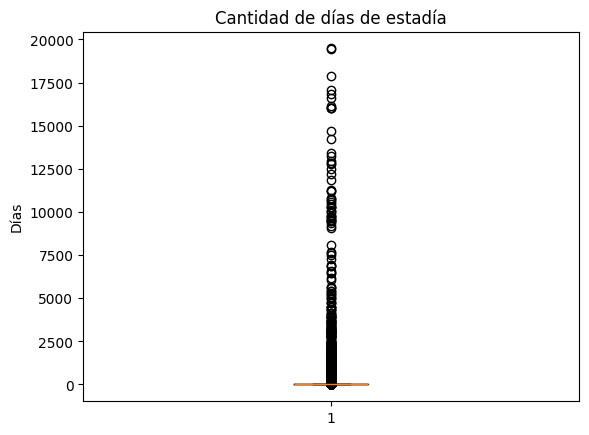

In [10]:
dias_estada = ds['DIAS_ESTADA']

plt.boxplot(dias_estada)
plt.title("Cantidad de días de estadía")
plt.ylabel("Días")
plt.show()

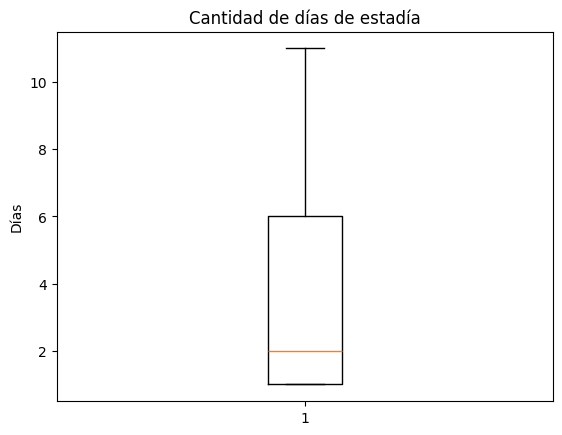

In [11]:
dias_estada = ds_numeric['DIAS_ESTADA']

plt.boxplot(dias_estada)
plt.title("Cantidad de días de estadía")
plt.ylabel("Días")
plt.show()

## Visualización de datos

Una vez realizada la limpieza de los datos, se procede a realizar una visualización general de los mismos. Esto fue necesario para asegurarnos de que fueran lo suficientemente representativos y observar cómo estaban distribuidos, con el fin de poder formular preguntas interesantes.

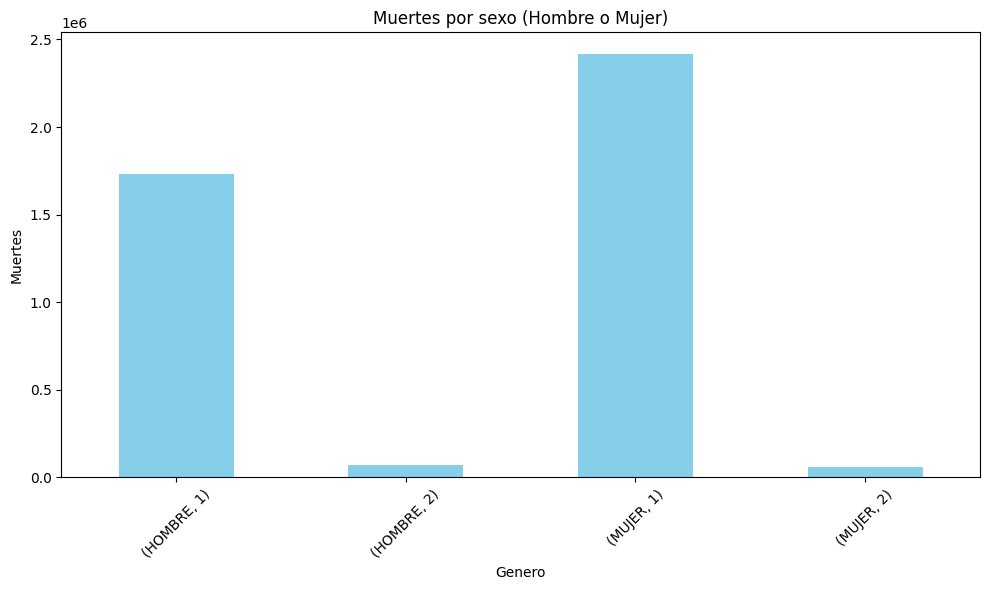

In [12]:
mortalidad = ds[ds['SEXO'].isin(['HOMBRE', 'MUJER'])].groupby('SEXO')['CONDICION_EGRESO'].value_counts()
plt.figure(figsize=(10, 6))
mortalidad.plot(kind='bar', color='skyblue')
plt.xlabel('Genero')
plt.ylabel('Muertes')
plt.title('Muertes por sexo (Hombre o Mujer)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Como se puede observar, se elaboró un gráfico de barras para examinar la condición de egreso de los pacientes clasificados por sexo. Cabe destacar que se tomó la decisión de no incluir a las personas no binarias, debido a la escasez de datos sobre este grupo. De hecho, la falta de información era tal que no se registraron fallecimientos de personas no binarias, además de tener una presencia prácticamente nula. A pesar de no ser consideradas en este gráfico, sí están incluidas en todos los demás análisis.

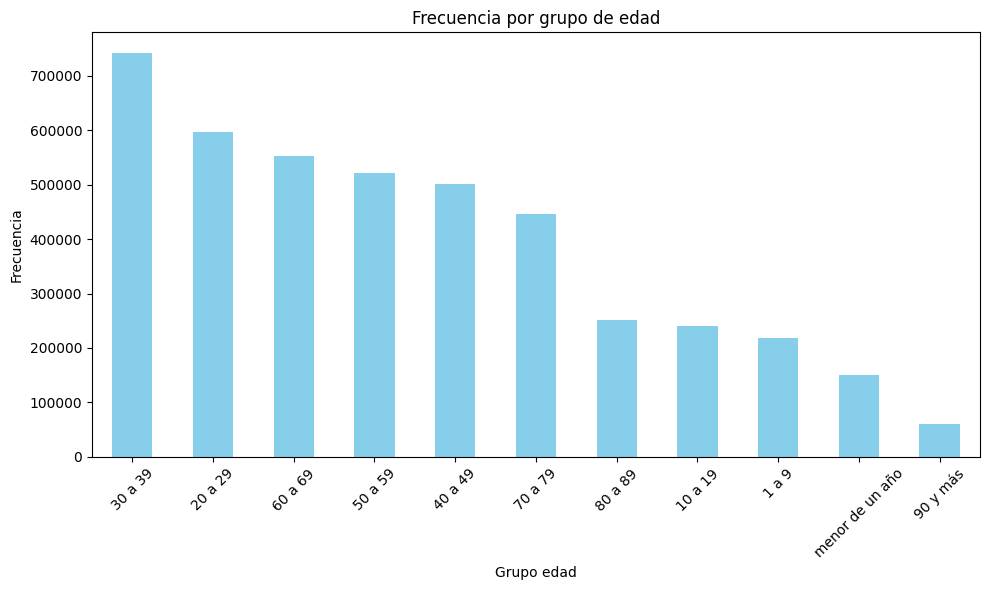

In [13]:
value_counts = ds['GRUPO_EDAD'].value_counts()

plt.figure(figsize=(10, 6))
value_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Grupo edad')
plt.ylabel('Frecuencia')
plt.title('Frecuencia por grupo de edad')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

El histograma muestra la distribución de grupos etarios, desde infantes menores de un año hasta personas mayores de 90 años, con un grupo para cada década, a excepción de los dos grupos mencionados anteriormente. Se observa una tendencia hacia las personas de entre 30 y 39 años, además de notar que entre los 20 y los 79 años se registra una mayor frecuencia que en los grupos fuera de ese rango de edad.

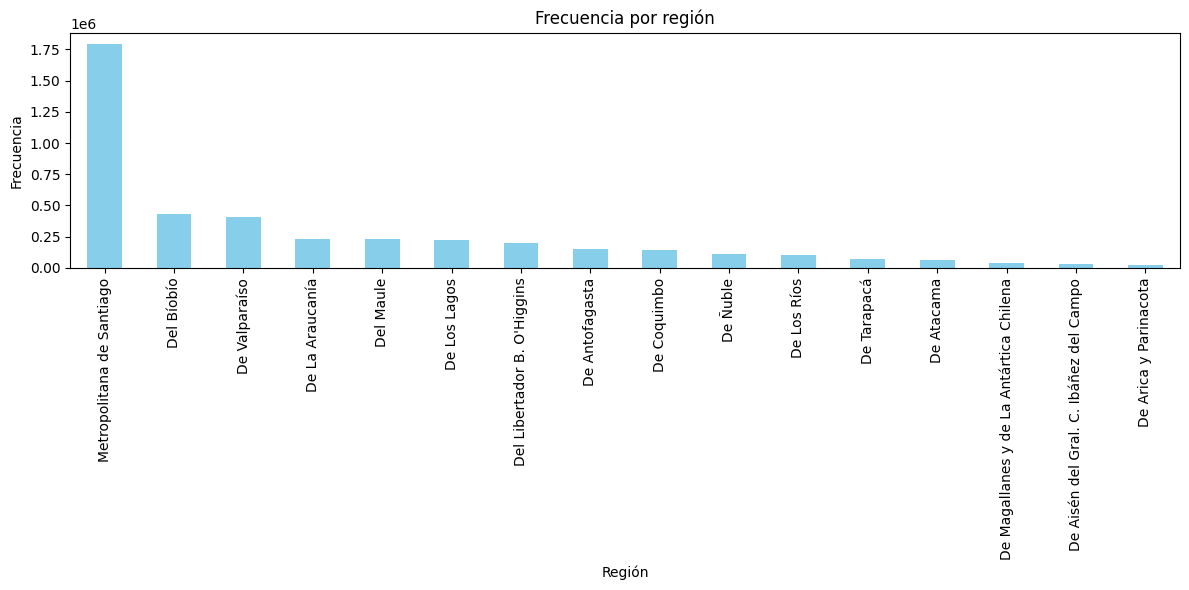

In [14]:
value_counts = ds['GLOSA_REGION_RESIDENCIA'].value_counts()

plt.figure(figsize=(12, 6))
value_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Región')
plt.ylabel('Frecuencia')
plt.title('Frecuencia por región')
plt.tight_layout()
plt.show()

El histograma de frecuencias por región muestra una clara tendencia en la Región Metropolitana, lo cual es esperable debido a su gran cantidad de habitantes en comparación con las demás regiones.

Para analizar estos datos de mejor manera normalizaremos la frecuencia de cada región por su cantidad de habitantes, para esto buscaremos este dato en el censo de 2017 con el fin de crear el diccionario 'poblacion'

In [15]:
poblacion = {
    'De Tarapacá': 330558,
    'De Antofagasta': 607534,
    'De Atacama': 	286168,
    'De Coquimbo': 757586,
    'De Valparaíso': 1815902,
    'Del Libertador B. O\'Higgins': 914555,
    'Del Maule': 1044950,
    'Del Bíobío': 1556805,
    'De La Araucanía': 957224,
    'De Los Lagos': 828708,
    'De Aisén del Gral. C. Ibáñez del Campo': 103158,
    'De Magallanes y de La Antártica Chilena': 166533,
    'Metropolitana de Santiago': 7112808,
    'De Los Ríos': 384837,
    'De Arica y Parinacota': 226068,
    'De Ñuble': 480609
}

C:\Users\joako\AppData\Local\Temp\ipykernel_11980\1769783062.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.25197151392249023' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  normalized_value_counts[region] = value_counts[region] / poblacion[region]


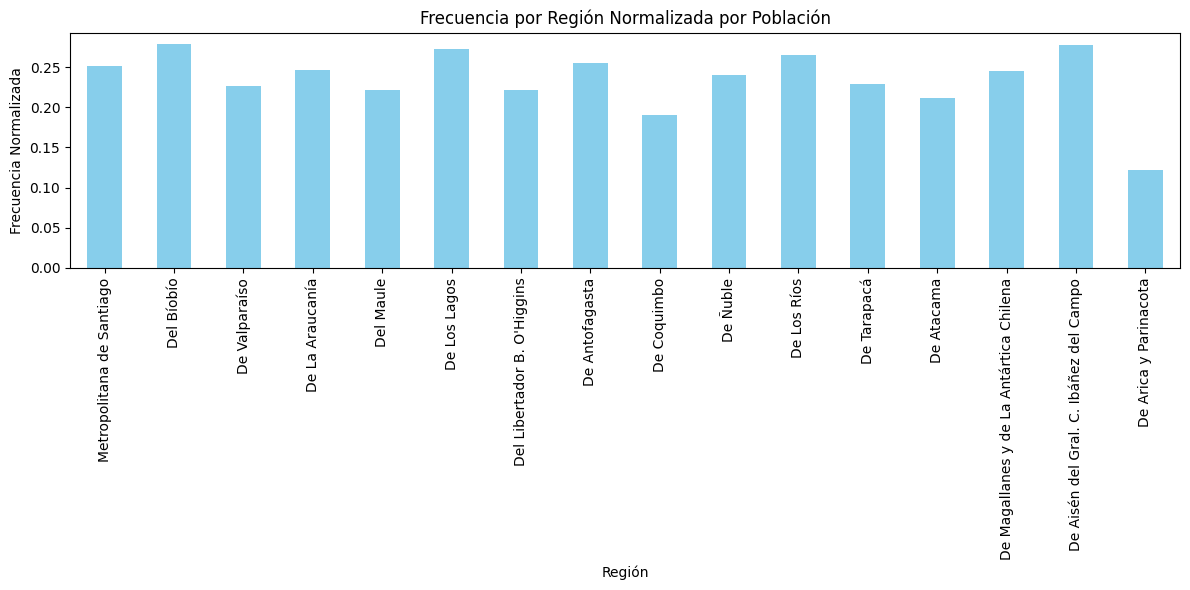

In [16]:
value_counts = ds['GLOSA_REGION_RESIDENCIA'].value_counts()

normalized_value_counts = value_counts.copy()
for region in value_counts.index:
    normalized_value_counts[region] = value_counts[region] / poblacion[region]

plt.figure(figsize=(12, 6))
normalized_value_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Región')
plt.ylabel('Frecuencia Normalizada')
plt.title('Frecuencia por Región Normalizada por Población')
plt.tight_layout()
plt.show()

## Relaciones entre los datos

A continuación se muestra un gráfico en el que se puede ver la distribución de días de estadía de las personas conforme a si estas han sido intervenidas quirúrgicamente o no. Notamos que, considerando a las personas no operadas, la diferencia entre aquellas que solo pasan un día y aquellas que pasan más de 10 días es mucho menor con respecto a la diferencia de aquellas personas que sí han sido operadas, en donde se observa que cerca del 45% de las personas tienen una estadía de un día, mientras que menos de un 10% tiene una estadía de más de 10 días. En el caso de las personas no operadas ambos resultados son cercanos al 20% (22% aprox para 1 día de estadía y 17% aprox para una cantidad de días mayor a 10). Con esto, es posible concluir que las operaciones son relevantes al momento de considerar la cantidad de días de estadía de un paciente.

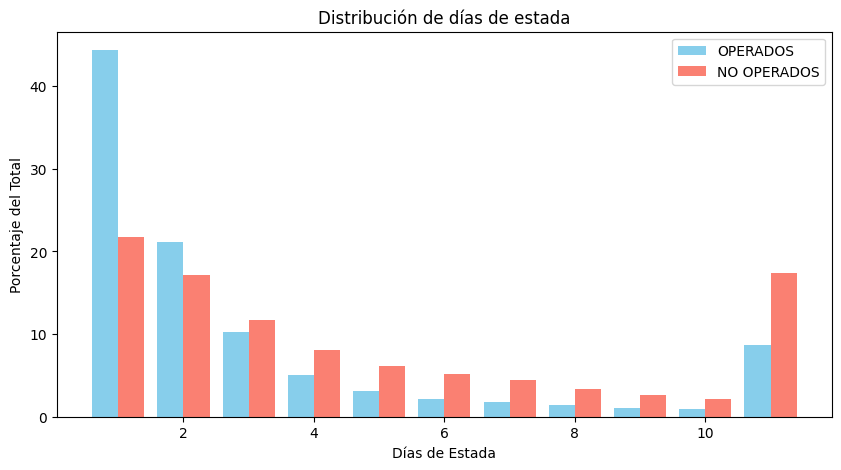

In [17]:
ds_op = ds_numeric[ds_numeric['INTERV_Q'] == 1]['DIAS_ESTADA']
ds_nop = ds_numeric[ds_numeric['INTERV_Q'] == 2]['DIAS_ESTADA']

ds_op_counts = ds_op.value_counts()
ds_nop_counts = ds_nop.value_counts()

total_op = ds_op_counts.sum()
total_nop = ds_nop_counts.sum()
ds_op_percentages = ds_op_counts / total_op * 100
ds_nop_percentages = ds_nop_counts / total_nop * 100

plt.figure(figsize=(10, 5))

plt.bar(ds_op_percentages.index - 0.2, ds_op_percentages.values, width=0.4, color='skyblue', label='OPERADOS')
plt.bar(ds_nop_percentages.index + 0.2, ds_nop_percentages.values, width=0.4, color='salmon', label='NO OPERADOS')

plt.title('Distribución de días de estada')
plt.xlabel('Días de Estada')
plt.ylabel('Porcentaje del Total')
plt.legend()

plt.show()

De manera similar al gráfico anterior, en este también se puede observar la distribución de días, esta vez considerando la pertenencia del paciente al sistema nacional de salud (SNS). Aquí, considerando al grupo que no pertenecen al SNS, se puede observar claramente que la diferencia entre la cantidad de personas que pasan un día en el establecimiento (cerca del 50% del total) y aquellas que pasan más de 10 días (menos del 10%) es mucho mayor que en el caso de las personas que sí pertenecen al SNS, donde ambos porcentajes son relativamente similares (cerca del 20%). Luego también se distingue que la pertenencia al SNS es relevante al momento de analizar la cantidad de días de estadía.

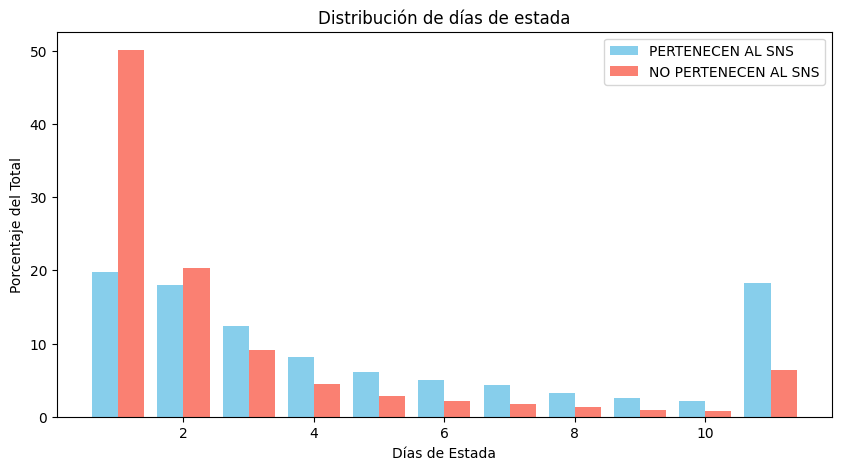

In [18]:
ds_ssn = ds_numeric[ds_numeric['PERTENENCIA_ESTABLECIMIENTO_SALUD'] == 1]['DIAS_ESTADA']
ds_nssn = ds_numeric[ds_numeric['PERTENENCIA_ESTABLECIMIENTO_SALUD'] == 2]['DIAS_ESTADA']
ds_ssn_counts = ds_ssn.value_counts()
ds_nssn_counts = ds_nssn.value_counts()
total_ssn = ds_ssn_counts.sum()
total_nssn = ds_nssn_counts.sum()
ds_ssn_percentages = ds_ssn_counts / total_ssn * 100
ds_nssn_percentages = ds_nssn_counts / total_nssn * 100

plt.figure(figsize=(10, 5))
plt.bar(ds_ssn_percentages.index - 0.2, ds_ssn_percentages.values, width=0.4, color='skyblue', label='PERTENECEN AL SNS')
plt.bar(ds_nssn_percentages.index + 0.2, ds_nssn_percentages.values, width=0.4, color='salmon', label='NO PERTENECEN AL SNS')

plt.title('Distribución de días de estada')
plt.xlabel('Días de Estada')
plt.ylabel('Porcentaje del Total')
plt.legend()

plt.show()

Este bloque de código se centra en analizar y visualizar las diferencias en las estadías hospitalarias entre pacientes que fueron operados y aquellos que no lo fueron, desglosado por regiones de Chile. El análisis comienza con la agrupación de los datos del conjunto de egresos hospitalarios, calculando la estadía promedio para cada combinación de región y categoría de intervención quirúrgica.

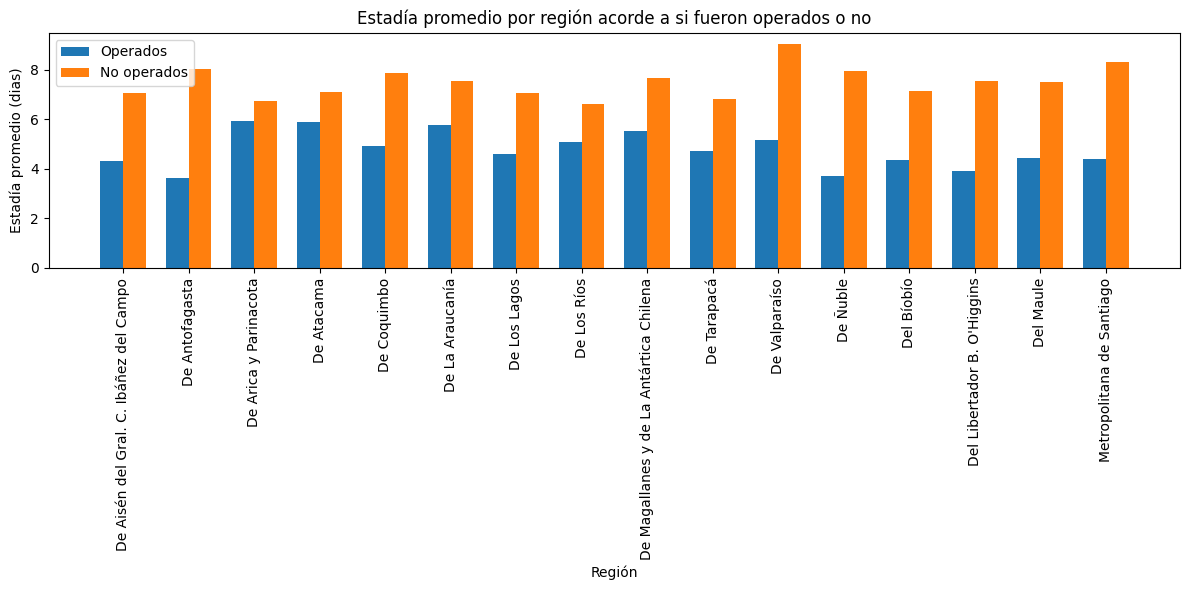

In [19]:

avg_days_table = ds.groupby(['GLOSA_REGION_RESIDENCIA', 'INTERV_Q'])['DIAS_ESTADA'].mean().reset_index()
avg_days_pivot = avg_days_table.pivot_table(index='GLOSA_REGION_RESIDENCIA', columns='INTERV_Q', values='DIAS_ESTADA', fill_value=0)
avg_days_pivot.reset_index(inplace=True)
num_bars = avg_days_pivot.shape[0]
bar_width = 0.35
x = np.arange(num_bars)
regions = avg_days_pivot['GLOSA_REGION_RESIDENCIA']
interq_1_data = avg_days_pivot[1]
interq_2_data = avg_days_pivot[2]


plt.figure(figsize=(12, 6))
plt.bar(x, interq_1_data, width=bar_width, label='Operados')
plt.bar(x + bar_width, interq_2_data, width=bar_width, label='No operados')
plt.xlabel('Región')
plt.ylabel('Estadía promedio (dias)')
plt.title('Estadía promedio por región acorde a si fueron operados o no')
plt.xticks(x + bar_width / 2, regions, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


El gráfico resultante muestra claramente si existen diferencias significativas en la duración de las estadías entre los dos grupos de pacientes a lo largo de las regiones, facilitando así la identificación de patrones o necesidades específicas de gestión hospitalaria. Esta visualización es crucial para los administradores hospitalarios y los planificadores de políticas de salud, proporcionando una base sólida para tomar decisiones informadas sobre la asignación de recursos y la mejora de los protocolos de atención.

A continuación, vemos la frecuencia de enfermedades para todas las cantidades de estadía posibles en nuestro dataframe ds_categorical. Para cada valor disinto, guardamos las frecuencias por enfermedad en una lista.

In [20]:
unique_values = ds_categorical['DIAS_ESTADA'].unique().tolist()
int_values = [val for val in unique_values if isinstance(val, int)]
str_value = [val for val in unique_values if isinstance(val, str)]
int_values.sort()
unique_values = int_values + str_value
dias = []
for dia in unique_values:
    ds_dias = ds_categorical[ds_categorical['DIAS_ESTADA']==dia]
    dias.append((ds_dias['DIAG1'].value_counts(),dia) )

Por último, con el objetivo de visualizar y comprender la caracterización de los distintos días de estadía en relación con las enfermedades que llevan a estos períodos, a continuación se muestran gráficos de torta para mostrar la distribución de los diagnósticos más comunes para diferentes las distintas cantidades de días que se quedan los pacientes (Utilizando ds_categorical). Cada gráfico de torta representa un día de estadía específico y muestra los 10 diagnósticos más frecuentes durante ese período. Los colores en los gráficos de torta se asignan de manera consistente para cada diagnóstico en todos los gráficos, lo que facilita la comparación entre los diferentes períodos de estadía. Cada sector del gráfico de torta representa un diagnóstico y el tamaño del sector indica la proporción de casos asociados con ese diagnóstico en el período de estadía correspondiente.

C:\Users\joako\AppData\Local\Temp\ipykernel_11980\1824553693.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data.index, rotation=90)
C:\Users\joako\AppData\Local\Temp\ipykernel_11980\1824553693.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data.index, rotation=90)
C:\Users\joako\AppData\Local\Temp\ipykernel_11980\1824553693.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data.index, rotation=90)
C:\Users\joako\AppData\Local\Temp\ipykernel_11980\1824553693.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data.index, rotation=90)
C:\Users\joako\AppData\Local\Tem

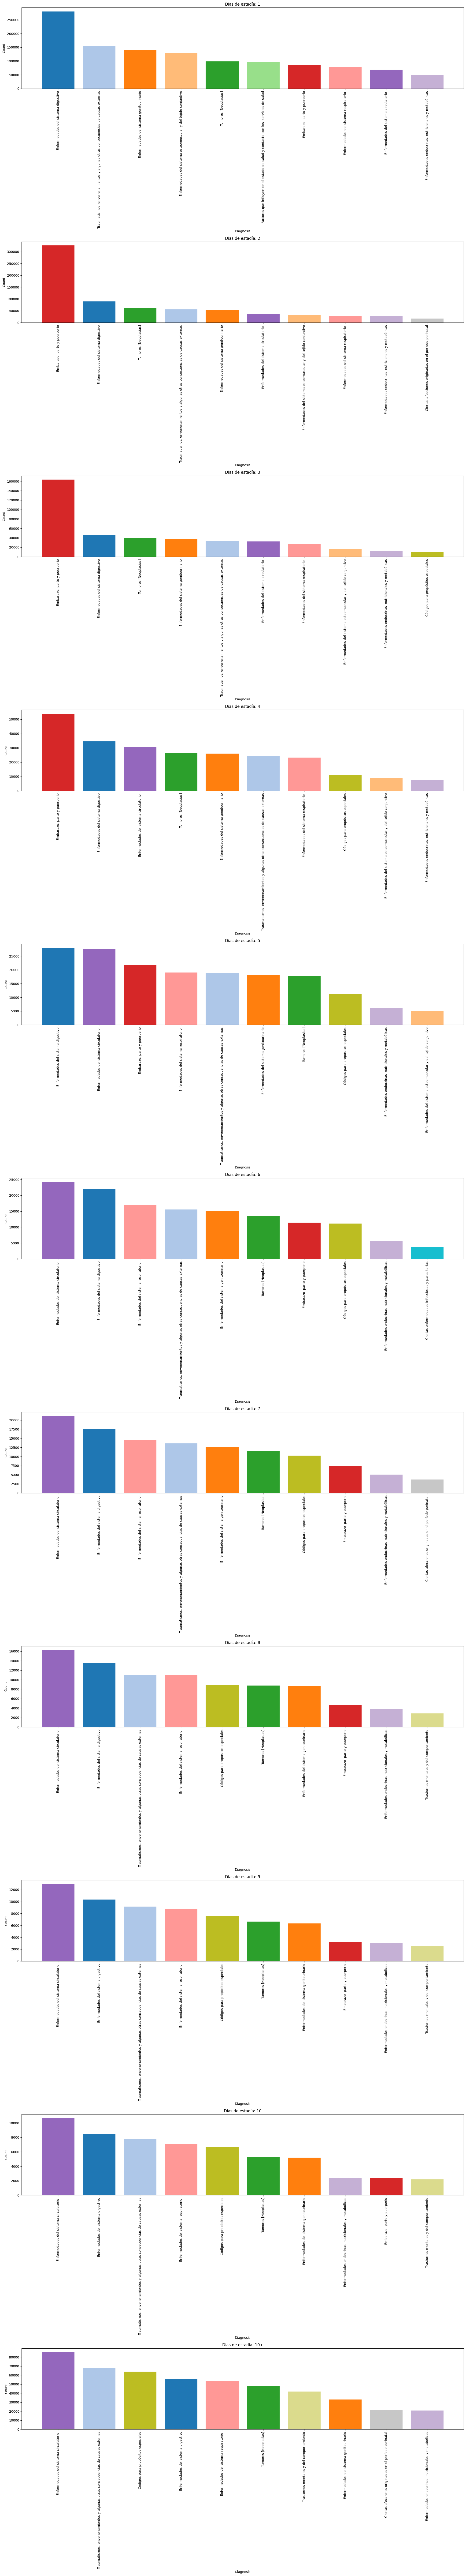

In [21]:
unique_values = ds_categorical['DIAS_ESTADA'].unique().tolist()
int_values = [val for val in unique_values if isinstance(val, int)]
str_values = [val for val in unique_values if isinstance(val, str)]
int_values.sort()
unique_values = int_values + str_values

dias = []
for dia in unique_values:
    ds_dias = ds_categorical[ds_categorical['DIAS_ESTADA'] == dia]
    dias.append((ds_dias['DIAG1'].value_counts(), dia))

all_diagnoses = pd.concat([dia[0] for dia in dias])
unique_diagnoses = all_diagnoses.index.unique()
color_map = {diag: plt.cm.tab20(i % 20) for i, diag in enumerate(unique_diagnoses)}

fig, axes = plt.subplots(nrows=len(dias), ncols=1, figsize=(20, 10 * len(dias)))
for i, ax in enumerate(np.ravel(axes)):
    data = dias[i][0][:10]
    colors = [color_map[diag] for diag in data.index]
    ax.bar(data.index, data.values, color=colors)
    ax.set_title("Días de estadía: " + str(dias[i][1]))
    ax.set_xlabel("Diagnosis")
    ax.set_ylabel("Count")
    ax.set_xticklabels(data.index, rotation=90)

# Ajusta el espacio en la parte inferior para acomodar los nombres de las enfermedades
plt.subplots_adjust(bottom=0.15)
plt.tight_layout()
plt.show()

Con estos gráficos se puede empezar a crear una relación entre los diagnosticos y el tiempo de estadía del paciente.

# Preguntas y problemas

La capacidad de predecir la duración de la estadía de un paciente adquiere una relevancia crucial. Esta predicción proporciona un entendimiento más profundo de cuán saturado puede estar un hospital, en relación con su tasa de ocupación, y cómo esta situación podría evolucionar en el futuro.

Al comprender mejor la duración esperada de la estadía de los pacientes, los administradores hospitalarios pueden anticipar y planificar de manera más efectiva la distribución de recursos, como camas, personal médico y suministros. Esta anticipación permite una respuesta más ágil a las necesidades de atención médica de la población, evitando la saturación y mejorando la calidad del servicio ofrecido.

De estas maneras las preguntas a responder durante el transcurso del proyecto serán:

¿Se puede predecir la cantidad de días de estadía de un paciente sabiendo su edad, sexo, región, pertenencia al sistema nacional de salud, y diagnostico/intervencion quirúrgica? Clasificación - Damián

¿Se pueden clasificar los pacientes en grupos con distinto nivel de urgencia de atención según  su edad, sexo, región, pertenencia al sistema nacional de salud, y diagnostico/intervencion quirúrgica? Clusters - Cachis

¿Cuáles son los factores que influyen en la condición de egreso del paciente (si sobrevive o no) considerando variables como edad, sexo, región, pertenencia al sistema nacional de salud, diagnóstico principal y si fue intervenido quirúrgicamente? Random forest - Pancho


# Aportes personales

Para lograr completar el proyecto, el equipo de trabajo se repartió las labores de la siguiente manera:

Claudio Morel: Desarrollo el componente visual  de la presentación grupal, realizó los gráficos de "Operados y No operados" y "Pertenecientes y no pertenecientes al SNS" y también concretó las preguntas finales del proyecto. Además ayudó a la limpieza y modificación de atributos y con la redacción general del informe.

Damián Gonzalez: Aportó al analisis inicial de los datos, ayudando a identificar la motivación. Además, se dedicó a explicar y crear los gráficos generados en la sección de exploracción de datos. Además ayudó a la limpieza y modificación de atributos y con la redacción general del informe.

Joaquín Gonzalez: Desarrollo y explico el apartado de visualización de la exploración y además aportó en la creación general de los gráficos del proyecto. Además ayudó a la redacción general del informe.

Nicolás Soto: Se dedicó en gran parte a la implementación técnica para la creación de gráficos y ayudó a la explicación del código asociado a esto. Además ayudó a la redacción general del informe.

Francisco Márquez: Trabajó principalmente en la manipulación directa de los datos, generando los filtraciones de datos y la reasignación de valores de los atributos. También generó código para la creación de los gráficos, en particular para ilustrar la limpieza (Gráficos de boxplot) y el gráfico de "Estadía promedio por región". Además ayudó a la redacción general del informe.

# Hito 2

Antes de poder experimentar transformaremos los datos string a unn valor int para que lo pueda soportar el modelo, además de dropear los datos con valor NaN de diagnostico para evitar problemaS

Transformamos el sexo del paciente tal que es 1 si es hombre, 2 si es mujer y 3 si es indeterminado

In [22]:
ds_exp = ds_numeric
ds_exp['SEXO'] = ds_exp['SEXO'].apply(lambda x: 1 if x == 'HOMBRE' else 2 if x == 'MUJER' else 3 if x == 'INTERSEX (INDETERMINDADO)' else x)

Como los grupos etarios son un string que describe el rango utilizamos un diccionario para convertirlos en un string

In [23]:
mapeo_edades = {
    'menor de un año': 0,
    '1 a 9': 1,
    '10 a 19': 2,
    '20 a 29': 3,
    '30 a 39': 4,
    '40 a 49': 5,
    '50 a 59': 6,
    '60 a 69': 7,
    '70 a 79': 8,
    '80 a 89': 9,
    '90 y más': 10
}

ds_numeric['GRUPO_EDAD'] = ds_numeric['GRUPO_EDAD'].map(mapeo_edades)

Utiliando los valores unique de le asignamos un id a cada diagnóstico

In [24]:
mapeo_diagnostico = {
    'Malformaciones congénitas, deformidades y anomalías cromosómicas': 1,
    'Factores que influyen en el estado de salud y contacto con los  servicios de salud': 2,
    'Enfermedades del sistema genitourinario': 3,
    'Enfermedades del sistema respiratorio ': 4,
    'Traumatismos, envenenamientos y algunas otras consecuencias de causas externas': 5,
    'Enfermedades de la piel y del tejido subcutáneo': 6,
    'Enfermedades del ojo y sus anexos ': 7,
    'Enfermedades del sistema digestivo': 8,
    'Enfermedades del sistema circulatorio ': 9,
    'Ciertas enfermedades infecciosas y parasitarias': 10,
    'Enfermedades del sistema osteomuscular y del tejido conjuntivo': 11,
    'Enfermedades del sistema nervioso central': 12,
    'Enfermedades de la sangre y de los órganos hematopoyéticos, y ciertos trastornos que afectan el mecanismo de la inmunidad ': 13,
    'Enfermedades endocrinas, nutricionales y metabólicas': 14,
    'Códigos para propósitos especiales': 15,
    'Síntomas, signos y hallazgos anormales clínicos y de laboratorio, no clasificados en otra parte': 16,
    'Tumores [Neoplasias]': 17,
    'Enfermedades del oído y de la apófisis mastoides': 18,
    'Trastornos mentales y del comportamiento': 19,
    'Ciertas afecciones originadas en el período perinatal': 20,
    'Embarazo, parto y puerperio': 21
}

ds_numeric['DIAG1'] = ds_numeric['DIAG1'].map(mapeo_diagnostico)

Detectamos que algunas regiones tenían su número como string, por lo que transformamos los valores a int

In [25]:
ds_exp['REGION_RESIDENCIA'] = ds_exp['REGION_RESIDENCIA'].apply(lambda x: int(x))


Finalmente dropeamos los valores con diagnóstico NaN

In [26]:
ds_exp = ds_exp.dropna(subset=['DIAG1'])

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


# Seleccionar características y variable objetivo
features = ['PERTENENCIA_ESTABLECIMIENTO_SALUD', 'SEXO', 'GRUPO_EDAD', 'REGION_RESIDENCIA', 'DIAG1', 'INTERV_Q']
target = 'DIAS_ESTADA'

# Definir el tamaño de la muestra
sample_size = 100000  # Ajusta este valor según tus necesidades

# Tomar una muestra aleatoria del dataset
ds_sample = ds_exp.sample(n=sample_size, random_state=0)

# Ahora puedes reemplazar 'ds' con 'ds_sample' en tu código
data = ds_sample[features + [target]]

# Definir las clases de la variable objetivo
clases = {
    'Corta Estancia': [1, 2, 3],
    'Estancia Media': [4, 5, 6],
    'Estancia Larga': [7, 8, 9],
    'Estancia Prolongada': list(range(10, max(data[target]) + 1))
}

# Asignar las clases a la variable objetivo
data['DIAS_ESTADA'] = pd.cut(data['DIAS_ESTADA'], bins=[0, 3, 6, 9, float('inf')], labels=clases.keys())

# Convertir características categóricas en variables numéricas usando codificación one-hot
# data_encoded = pd.get_dummies(data, columns=['PERTENENCIA_ESTABLECIMIENTO_SALUD', 'SEXO', 'GRUPO_EDAD', 'GLOSA_REGION_RESIDENCIA', 'DIAG1', 'INTERV_Q'])

# Dividir el dataset en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(data.drop(target, axis=1), data[target], test_size=0.3, random_state=0)

C:\Users\joako\AppData\Local\Temp\ipykernel_11980\1633274143.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['DIAS_ESTADA'] = pd.cut(data['DIAS_ESTADA'], bins=[0, 3, 6, 9, float('inf')], labels=clases.keys())


In [28]:
from sklearn.tree import DecisionTreeClassifier
# Crear y entrenar el modelo
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)

# Hacer predicciones
y_pred = clf.predict(X_test)

clf_acc = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

     Corta Estancia       0.70      0.89      0.78     18525
     Estancia Larga       0.12      0.05      0.07      2303
     Estancia Media       0.23      0.10      0.14      4629
Estancia Prolongada       0.38      0.28      0.32      4543

           accuracy                           0.61     30000
          macro avg       0.36      0.33      0.33     30000
       weighted avg       0.53      0.61      0.56     30000



In [29]:
from sklearn.naive_bayes import GaussianNB
nb_clf = GaussianNB()

nb_clf.fit(X_train, y_train)

y_pred = nb_clf.predict(X_test)

nb_acc = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

c:\Users\joako\Documents\Tareas\mineria\min\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                     precision    recall  f1-score   support

     Corta Estancia       0.68      0.92      0.78     18525
     Estancia Larga       0.00      0.00      0.00      2303
     Estancia Media       0.00      0.00      0.00      4629
Estancia Prolongada       0.30      0.33      0.32      4543

           accuracy                           0.62     30000
          macro avg       0.25      0.31      0.27     30000
       weighted avg       0.47      0.62      0.53     30000



c:\Users\joako\Documents\Tareas\mineria\min\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\joako\Documents\Tareas\mineria\min\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [30]:
from sklearn.svm import SVC
sv_clf = SVC(C=1.0, kernel='rbf')

sv_clf.fit(X_train, y_train)

y_pred = sv_clf.predict(X_test)

sv_acc = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rd_clf = RandomForestClassifier()

rd_clf.fit(X_train, y_train)

y_pred = rd_clf.predict(X_test)

rd_acc = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

     Corta Estancia       0.71      0.85      0.77      1851
     Estancia Larga       0.11      0.05      0.07       221
     Estancia Media       0.22      0.11      0.15       481
Estancia Prolongada       0.32      0.30      0.31       447

           accuracy                           0.59      3000
          macro avg       0.34      0.33      0.32      3000
       weighted avg       0.53      0.59      0.55      3000



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
kn_clf = KNeighborsClassifier(n_neighbors=5)

kn_clf.fit(X_train, y_train)

y_pred = kn_clf.predict(X_test)

kn_acc = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))


                     precision    recall  f1-score   support

     Corta Estancia       0.69      0.89      0.78      1851
     Estancia Larga       0.12      0.05      0.08       221
     Estancia Media       0.20      0.11      0.14       481
Estancia Prolongada       0.32      0.19      0.24       447

           accuracy                           0.60      3000
          macro avg       0.33      0.31      0.31      3000
       weighted avg       0.52      0.60      0.54      3000



In [ ]:
from sklearn.dummy import DummyClassifier
dm_clf = DummyClassifier(strategy='stratified')

dm_clf.fit(X_train, y_train)

y_pred = dm_clf.predict(X_test)

dm_acc = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

     Corta Estancia       0.62      0.63      0.62      1851
     Estancia Larga       0.10      0.10      0.10       221
     Estancia Media       0.13      0.12      0.12       481
Estancia Prolongada       0.13      0.14      0.13       447

           accuracy                           0.44      3000
          macro avg       0.24      0.24      0.24      3000
       weighted avg       0.43      0.44      0.43      3000



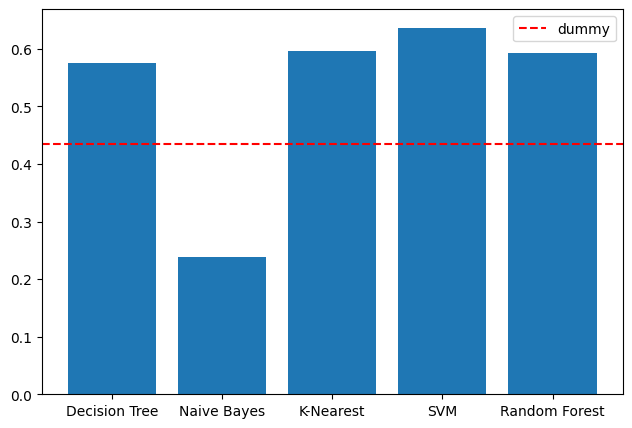

In [ ]:
dt_acc = accuracy_score(y_test, clf.predict(X_test))

fig, ax = plt.subplots(figsize=(7.5, 5))

accuracies = [dt_acc, nb_acc, kn_acc, sv_acc, rd_acc]
classifires = ['Decision Tree', 'Naive Bayes', 'K-Nearest', 'SVM', 'Random Forest']

ax.bar(classifires, accuracies)
ax.axhline(dm_acc, color='r', linestyle='--', label='dummy')

ax.legend()

plt.show()